# Welcome to Airbnb Data Analysis's notebook
To run all the code, you can use the "run all" function. You can also follow along and run the code accordingly. Note that we assume this project to be running with ***Jupyter Notebook***.

## 1. Dependencies
We have recorded all the required dependencies in `requirements.txt`, to get all the dependencies installed, simply run the below's code.

In [1]:
%pip install -r requirements.txt --user

## 2. Project setup
Below cell imports all the library needed and do some global setting for the dataframes.

In [2]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import re
import seaborn as sns
import numpy as np
from textblob import TextBlob
from langdetect import detect
import xgboost as xgb
from forex_python.converter import CurrencyRates
from scipy import stats

pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000
pd.options.display.max_colwidth = 100

## 3. Reading in data
In this project, we have stored all our main data in `main_data/` and review data`review_data/`. Run the cell below to grab all the `.csv` data from the folder and load it into a single dataframe.

In [3]:
# get all data for main
path_main = os.getcwd() + "\\main_data"
main_all = glob.glob(os.path.join(path_main, "*.csv"))
df = pd.concat((pd.read_csv(f, header=0, sep = ';', low_memory=False) for f in main_all))

# get all data for reviews
path_review = os.getcwd() + "\\review_data"
review_all = glob.glob(os.path.join(path_review, "*.csv"))
review_df = pd.concat((pd.read_csv(f) for f in review_all))

In [4]:
df.head()

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host ID,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,9902936,https://www.airbnb.com/rooms/9902936,20170509084238,2017-05-09,70's Retro Viennese Apartment 6 min to City Center,Gemütliches & trendiges Retro Apartment mit originären Elementen der 70er vermittelt ein authent...,Modernes 60 m² Wiener Retro-Apartment. In unmittelbarer Nähe der Innenstadt. Direkt angrenzend a...,Gemütliches & trendiges Retro Apartment mit originären Elementen der 70er vermittelt ein authent...,none,In unmittelbarer Umgebung befindet sich der Donaukanal mit seinem unvergleichlichen Charme. Zur ...,•Nichtraucher Apartment •Ruhezeiten zwischen 20:00 (8 pm) und 06:00 (6 am) sind strikt einzuhalten,Die nächste U-Bahnstation ist etwa drei Gehminuten entfernt und bietet somit einen hervorragende...,"Kochen, Internet, TV",Für Ihren entspannten Urlaub haben wir Kaffee (gegen separates Entgelt) vorbereitet. Als zusätzl...,Hausregeln •\tNicht Raucher Apartment! •\tRuhezeiten zwischen 20:00-6:00 müssen strikt eingehalt...,https://a0.muscache.com/im/pictures/ba2a1465-718a-49a5-ae95-a80c42105f0d.jpg?aki_policy=small,https://a0.muscache.com/im/pictures/ba2a1465-718a-49a5-ae95-a80c42105f0d.jpg?aki_policy=medium,https://public.opendatasoft.com/api/v2/catalog/datasets/airbnb-listings/files/37e347094d5b43579b...,https://a0.muscache.com/im/pictures/ba2a1465-718a-49a5-ae95-a80c42105f0d.jpg?aki_policy=x_large,24420353,https://www.airbnb.com/users/show/24420353,Roman,2014-12-02,"Vienna, Vienna, Austria","Ich reise gern, bin neugierig, sehr kommunikativ, liebe Sport und freue mich, Gäste aus der ganz...",within an hour,100.0,NaN,https://a0.muscache.com/im/users/24420353/profile_pic/1418065454/original.jpg?aki_policy=profile...,https://a0.muscache.com/im/users/24420353/profile_pic/1418065454/original.jpg?aki_policy=profile...,Mariahilf,9.0,9.0,"email,phone,reviews,jumio","Leopoldstadt, Wien, Wien 1020, Austria",Leopoldstadt,Leopoldstadt,NaN,Wien,Wien,1020,Vienna,"Wien, Austria",AT,Austria,48.215747,16.374918,Apartment,Entire home/apt,4,1.0,2.0,2.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Wheelchair accessible,Kitchen,Elevator in building,Buzzer...",NaN,69.0,NaN,NaN,150.0,59.0,2,12.0,2,1125,6 days ago,NaN,6,15,23,265,2017-05-09,67,2016-03-26,2017-04-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,strict,4,4.90,"48.2157468305,16.3749181321","Host Is Superhost,Host Has Profile Pic,Host Identity Verified,Is Location Exact"
1,16932319,https://www.airbnb.com/rooms/16932319,20170509084238,2017-05-09,Charming Retreat in City Center,Our newly renovated apartment with balcony offers privacy away from the city buzz but is close e...,"Newly renovated, modern furnishing and appliances, balcony, city views.",Our newly renovated apartment with balcony offers privacy away from the city buzz but i

In [5]:
review_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,15883,29643839,2015-04-10,30537860,Robert,"If you need a clean, comfortable place to stay in Vienna, search no more - Eva's B&B is THE plac..."
1,15883,80590019,2016-06-19,37529754,Chuang,It's so nice to be in the house! It's a peace and beautiful place. Wed love it very much! Thank ...
2,15883,89583522,2016-07-29,3147341,Arber,"A beautiful place, uniquely decorated showing love to detail!\r<br/>Its near the Danube and away..."
3,15883,93550424,2016-08-13,29518067,Raphaela,Eine sehr schöne Unterkunft in einem privaten großen Haus mit sehr netten Gastgebern. Wir haben ...
4,15883,114990769,2016-11-21,36016357,Chris,It was a very pleasant stay. Excellent location. Very friendly host.<br/>Highly recommended.<br/>


## 4. Data cleaning
In this section, we clean the dataframes according to our needs.

Lets start by looking at the percentage of missing data per columns.

In [6]:
pd.set_option('display.max_rows', 100)
percent_missing = df.isnull().sum() * 100 / len(df)
df_missing = pd.DataFrame({"Percent Missing" : percent_missing})
df_missing.sort_values("Percent Missing", inplace = True, ascending = False)
df_missing

,Percent Missing
Has Availability,99.140099
Host Acceptance Rate,98.508916
License,97.926177
Square Feet,96.356370
Monthly Price,80.956884
Weekly Price,78.401871
Neighbourhood Group Cleansed,73.173992
Jurisdiction Names,67.268814
Notes,62.612961
Security Deposit,59.559056


First, we remove less significant columns that has too many missing values.

In [7]:
dropped_columns = ["Jurisdiction Names", "Host Acceptance Rate", "License", "Has Availability", "Square Feet",
                   "Monthly Price", "Weekly Price", "Notes", "Interaction", "Access",
                   "Neighborhood Overview", "Neighbourhood Group Cleansed", "Neighbourhood", "Host About",
                   "Host Name", "Host Location", "Host Neighbourhood", "Street"]

df.drop(columns = dropped_columns, inplace = True)

From the data, we can see that there are a lots of urls, repeating columns, and redundant columns that we can't process. Let's remove them.

In [8]:
dropped_columns = ["Listing Url", "Scrape ID", "Name", "Summary", "Space", "Transit", "House Rules",
                   "Thumbnail Url", "Medium Url", "Picture Url", "XL Picture Url", "Host ID", "Host URL",
                   "Host Thumbnail Url", "Host Picture Url", 'Calendar last Scraped', 'Last Scraped',
                   'Experiences Offered', 'Country', "Geolocation", "Market", "Zipcode"]

df.drop(columns = dropped_columns, inplace = True)

We have cleaned a lot of columns, now lets check for the remaining null values.

In [9]:
df.isnull().sum()

ID                                     0
Description                           73
Host Since                            65
Host Response Time                 49523
Host Response Rate                 49523
Host Listings Count                   65
Host Total Listings Count             65
Host Verifications                   164
Neighbourhood Cleansed                 0
City                                  98
State                              19674
Smart Location                         0
Country Code                           0
Latitude                               0
Longitude                              0
Property Type                          0
Room Type                              0
Accommodates                           0
Bathrooms                            554
Bedrooms                             298
Beds                                 340
Bed Type                               0
Amenities                           1565
Price                               4221
Security Deposit

There is still a lot of null values left, lets deal with them. <br> <br>
First of all, we drop the rows with null values for `Bedrooms`, `Bathrooms`, `Price`, `Extra People`, `City` and `Beds`.

In [10]:
df.dropna(subset = ["Bedrooms", "Bathrooms", "Price", "Beds", "Extra People", "City"], inplace = True)

Now, we can set certain null values to 0, such as `Security Deposit` and `Cleaning Fee`, where null probably means 0 fee.

In [11]:
df["Security Deposit"].fillna(0., inplace = True)
df["Cleaning Fee"].fillna(0., inplace = True)

The same can be done for `Features`, `Host Verifications`, `Description` and `Amenities`. We can replace the null with an empty string.

In [12]:
df["Amenities"].fillna("", inplace = True)
df["Features"].fillna("", inplace = True)
df["Host Verifications"].fillna("", inplace = True)
df["Description"].fillna("", inplace = True)

Looking at the `Smart Location` and `State` column, we can see that they're mostly different ways to write the same thing but in different languages. We can also remove them as `City` is enough to determine the locations.

In [13]:
df["State"].unique()

array(['Wien', 'Vienna', 'Вена', nan, '欧洲', 'Österreich', 'Austria',
       'wien', 'Niederösterreich', 'Wieden', 'AT', '维也纳州',
       'Vienna Austria', '奥地利', 'Viena', 'ウィーン', '维也纳', 'Hietzing',
       'Zentrum', 'Vienne', 'Favoriten', 'Wiedeń', 'Oesterreich',
       'Leopoldstadt', 'Neubau', 'Bruxelles', 'woluwe saint pierre',
       'Brussels', 'Brussels Hoofdstedelijk Gewest', 'Brussel',
       'Region Brüssel-Hauptstadt', 'Vlaanderen', 'Flanders',
       'Flemish Region', 'Vlaams Gewest', 'Antwerpen', 'Belgique',
       'Deurne', 'BRUXELLES', '1000', 'Berchem', 'Région Flamande',
       'Neuve', 'laeken', 'Jette', 'Woluwe Saint Lambert',
       'Région de Bruxelles-Capitale', 'Koekelberg', 'Propre', 'Laeken',
       'Belgium', 'Brussel Hoofdstedelijk Gewest', 'Sint-joost-ten-node',
       '布鲁塞尔首都区', 'Antwerp', '1060', 'Ixelles',
       'Regione di Bruxelles-Capitale', 'Region Stołeczny Brukseli',
       'Brussels Capital', 'Bruselas', 'bruxelles',
       'region de Bruxelles Capit

In [14]:
df["Smart Location"].unique()

array(['Wien, Austria', 'Vienna, Austria', 'Вена, Austria', ...,
       'Dardagny, Switzerland', 'Vaticano, Vatican City',
       'Roma vaticano, Vatican City'], dtype=object)

In [15]:
df.drop(columns = ["State", "Smart Location"], inplace = True)

We can just set `Host Listings Count`, `Reviews per Month`, and `Host Total Listings Count` to the median of the respective column.

In [16]:
df["Host Listings Count"].fillna(df["Host Listings Count"].median(), inplace = True)
df["Host Total Listings Count"].fillna(df["Host Total Listings Count"].median(), inplace = True)
df["Reviews per Month"].fillna(df["Reviews per Month"].median(), inplace = True)

Looking at the review scores below:

In [17]:
print(f"Review Scores Rating : {df['Review Scores Rating'].median()}")
print(f"Review Scores Accuracy : {df['Review Scores Accuracy'].median()}")
print(f"Review Scores Checkin : {df['Review Scores Checkin'].median()}")
print(f"Review Scores Cleanliness : {df['Review Scores Cleanliness'].median()}")
print(f"Review Scores Communication : {df['Review Scores Communication'].median()}")
print(f"Review Scores Location : {df['Review Scores Location'].median()}")
print(f"Review Scores Value : {df['Review Scores Value'].median()}")

Review Scores Rating : 94.0
Review Scores Accuracy : 10.0
Review Scores Checkin : 10.0
Review Scores Cleanliness : 10.0
Review Scores Communication : 10.0
Review Scores Location : 10.0
Review Scores Value : 9.0


We can see that It seems that the scores are mostly 10/10. We can plot out the rating to take a brief look at the overall distribution.

<AxesSubplot:xlabel='Review Scores Rating', ylabel='Count'>

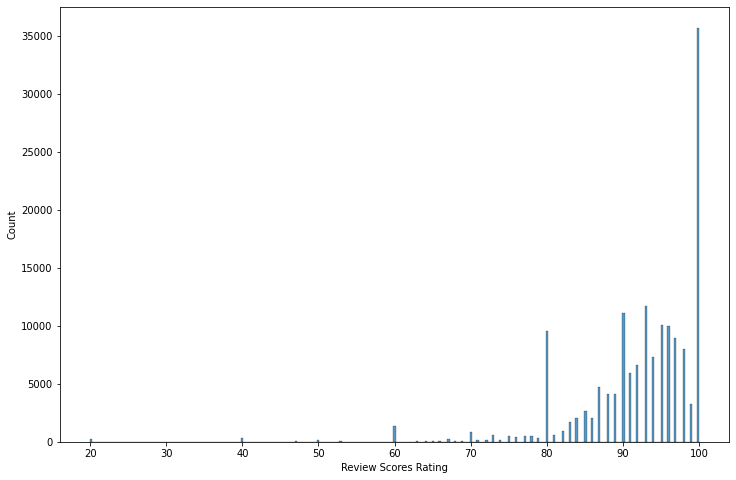

In [18]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df["Review Scores Rating"])

Most of the units are actually rated 100/100. We can drop the other more specific ratings and use the median of the ratings to fill in the null values.

In [19]:
df.drop(columns=["Review Scores Accuracy", "Review Scores Checkin", "Review Scores Cleanliness",
                   "Review Scores Communication", "Review Scores Location", "Review Scores Value"], inplace = True)

In [20]:
df["Review Scores Rating"].fillna(df["Review Scores Rating"].median(), inplace = True)

Let's look at `Host Since`, `First Review` and `Last Review`. We can convert them to a datetime object and then fill in the empty values with the median.

In [21]:
df["First Review"] = pd.to_datetime(df["First Review"])
df["Last Review"] = pd.to_datetime(df["Last Review"])
df["Host Since"] = pd.to_datetime(df["Host Since"])

df["Host Since"].fillna(df["Host Since"].quantile(0.5, interpolation="midpoint"), inplace = True)
df["First Review"].fillna(df["First Review"].quantile(0.5, interpolation="midpoint"), inplace = True)
df["Last Review"].fillna(df["Last Review"].quantile(0.5, interpolation="midpoint"), inplace = True)

Since `Host Response Rate` are floating values. We can replace the null values with the median. `Host Response Time` is a categorical variable. We can replace null values with the mode.

In [22]:
df["Host Response Rate"].fillna(df["Host Response Rate"].median(), inplace = True)

In [23]:
df["Host Response Time"].value_counts()

within an hour        83139
within a few hours    39792
within a day          32659
a few days or more     5742
Name: Host Response Time, dtype: int64

In [24]:
df["Host Response Time"].fillna("within an hour", inplace = True)

Since the currency rate of Denmark and Switzerland is not euro, we need to convert them to euro.

In [25]:
df.loc[df['Country Code'] == 'DK', 'Price'] = CurrencyRates().convert('DKK', 'EUR', df[df['Country Code'] == 'DK']['Price'])
df.loc[df['Country Code'] == 'CH', 'Price'] = CurrencyRates().convert('CHF', 'EUR', df[df['Country Code'] == 'CH']['Price'])

In [26]:
df.isnull().sum()

ID                                0
Description                       0
Host Since                        0
Host Response Time                0
Host Response Rate                0
Host Listings Count               0
Host Total Listings Count         0
Host Verifications                0
Neighbourhood Cleansed            0
City                              0
Country Code                      0
Latitude                          0
Longitude                         0
Property Type                     0
Room Type                         0
Accommodates                      0
Bathrooms                         0
Bedrooms                          0
Beds                              0
Bed Type                          0
Amenities                         0
Price                             0
Security Deposit                  0
Cleaning Fee                      0
Guests Included                   0
Extra People                      0
Minimum Nights                    0
Maximum Nights              

Now that we are done with main data, lets look at review data.

In [27]:
review_df.isnull().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      0
comments         815
dtype: int64

The data is pretty clean, with only comments that have missing value, lets remove them.

In [28]:
#before cleaning
review_df.shape

(3683932, 6)

In [29]:
review_df.dropna(inplace=True)

Lets make sure the `listing_id` from reviews data matches the main data

In [30]:
# remove listing not in main data
review_df = review_df[review_df.listing_id.isin(df.ID)]

In [31]:
#after cleaning
review_df.shape

(3275916, 6)

In [32]:
review_df.isnull().sum()

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

With this, we should be done with the data preprocessing.

## 5. Sentiment analysis
Before we start to do predictions and EDA, we should do sentiment analysis on the review data first.

To do the analysis, we need to preprocess and clean the text data with below function.

In [33]:
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove @ tags
    text = re.sub(r'#', '', text) # remove the # symbol
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove the hyper link
    text = re.sub(r'<[^>]*>', '', text) #Remove html tags
    return text

We will use the ***textblob*** and ***langdetect*** to get the polarity score and language respectively. <br><br>
To do that, we create 2 function for them.

In [34]:
def getLanguage(text):
    try:
        output = detect(clean_text(text))
    except:
        # if its empty string, than detect the language as None
        output=None
    return output

def getPolarity(text):
    
    text = TextBlob(clean_text(text))

    return text.sentiment.polarity

In case of there is any mistake made and we need to run the analysis again, we can create a copy of the actual data.

In [35]:
#copy incase there is any error
df_copy = df.copy()
review_df_copy = review_df.copy()

Now with all setup being done, we can start to run the analysis. <br><br> First, we get the polarity score for each review. (Since it take around 1 hour to finish the process, we will import the processed data instead)

In [36]:
# Below code run the analysis to the function, we commented it out and load the processed review data instead 
# review_df_copy['Comment Polarity'] = review_process["comments"].apply(getPolarity)

# get the processed review data.
review_df_copy = pd.read_csv('all_review_with_polarity.csv')

Now, we get the polarity score and language of the `Description` for the main data. (same as review, it may take a long time so we just import processed data instead.

In [37]:
# get language of description
# df_copy['Description Language'] = df_copy["Description"].apply(getLanguage)

# get polarity for description
# df_copy['Description Polarity'] = df_copy["Description"].apply(getPolarity)

# get the processed main data.
df_copy = pd.read_csv('processed_all_main_data.csv', sep=";")

In [38]:
# assign the copy back to the datafranes
df = df_copy
review_df = review_df_copy

In [39]:
df.head()

,ID,Description,Host Since,Host Response Time,Host Response Rate,Host Listings Count,Host Total Listings Count,Host Verifications,Neighbourhood Cleansed,City,Country Code,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,First Review,Last Review,Review Scores Rating,Cancellation Policy,Calculated host listings count,Reviews per Month,Features,Description Language,Description Polarity
0,9902936,Gemütliches & trendiges Retro Apartment mit originären Elementen der 70er vermittelt ein authent...,2014-12-02,within an hour,100.0,9.0,9.0,"email,phone,reviews,jumio",Leopoldstadt,Wien,AT,48.215747,16.374918,Apartment,Entire home/apt,4,1.0,2.0,2.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Wheelchair accessible,Kitchen,Elevator in building,Buzzer...",69.0,150.0,59.0,2,12.0,2,1125,6 days ago,6,15,23,265,67,2016-03-26,2017-04-29,96.0,strict,4,4.90,"Host Is Superhost,Host Has Profile Pic,Host Identity Verified,Is Location Exact",de,-0.700000
1,16932319,Our newly renovated apartment with balcony offers privacy away from the city buzz but is close e...,2014-11-08,within a few hours,90.0,3.0,3.0,"email,phone,reviews,jumio",Leopoldstadt,Wien,AT,48.225823,16.401469,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"Kitchen,Elevator in building,Heating,Family/kid friendly,Washer,Essentials,Shampoo,Hangers,Hair ...",69.0,150.0,45.0,2,19.0,3,28,4 weeks ago,12,37,67,321,5,2017-03-05,2017-04-30,96.0,strict,1,2.27,"Host Has Profile Pic,Host Identity Verified,Instant Bookable",en,0.173817
2,4086303,"our bright one bedroom apt is located in the center of vienna, in a neighborhood full of restau...",2010-08-27,within a few hours,100.0,1.0,1.0,"email,phone,reviews,work_email",Leopoldstadt,Vienna,AT,48.214652,16.379914,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,"TV,Wireless Internet,Kitchen,Heating,Family/kid friendly,Washer,Essentials,Hangers,Iron,Laptop f...",100.0,164.0,65.0,3,20.0,2,1125,5 weeks ago,3,33,63,338,3,2017-01-02,2017-04-24,93.0,strict,1,0.70,"Host Has Profile Pic,Is Location Exact",en,0.254762
3,13112862,Mein Premium Apartment Elegance ist in einem klassischen Wiener Jahrhundertwendehaus. Das Apartm...,2012-02-14,within an hour,100.0,3.0,3.0,"email,phone,facebook,reviews,jumio",Leopoldstadt,Wien,AT,48.222464,16.387926,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen,Elevator in building,Buzzer/wireless intercom,Hea...",75.0,0.0,40.0,1,0.0,2,185,today,5,9,32,302,50,2016-07-18,2017-05-05,100.0,strict,3,5.07,"Host Is Superhost,Host Has Profile Pic,Host Identity Verified,Is Location Exact,Instant Bookable",de,0.000000
4,16945823,Einen Katzensprung vom Stephansdom und der City entfernt. Unsere Wohnung ist ein gemütlicher Rüc...,2015-09-02,within an hour,100.0,2.0,2.0,"phone,reviews",Leopoldstadt,Wien,AT,48.216764,16.384622,Apartment,Entire home/apt,3,1.0,2.0,2.0,Real Bed,"TV,Wireless Internet,Kitchen,Elevator in building,Heating,Family/kid friendly,Essentials,Shampoo...",87.0,0.0,45.0,2,12.0,1,1125,a week ago,19,49,79,348,2,2017-04-17,2017-04-29,100.0,moderate,1,2.00,Host Has Profile Pic,de,0.106250


In [40]:
#remove the Unnamed: 0 generated accidentally when saving the .csv
review_df.drop(columns={'Unnamed: 0'}, inplace=True)
review_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,Comment Polarity
0,15883,29643839,2015-04-10,30537860,Robert,"If you need a clean, comfortable place to stay in Vienna, search no more - Eva's B&B is THE plac...",0.360227
1,15883,80590019,2016-06-19,37529754,Chuang,It's so nice to be in the house! It's a peace and beautiful place. Wed love it very much! Thank ...,0.626563
2,15883,89583522,2016-07-29,3147341,Arber,"A beautiful place, uniquely decorated showing love to detail!\r<br/>Its near the Danube and away...",0.245455
3,15883,93550424,2016-08-13,29518067,Raphaela,Eine sehr schöne Unterkunft in einem privaten großen Haus mit sehr netten Gastgebern. Wir haben ...,0.000000
4,15883,114990769,2016-11-21,36016357,Chris,It was a very pleasant stay. Excellent location. Very friendly host.<br/>Highly recommended.<br/>,0.813611


Next, we can find the average polarity for each listing.

In [41]:
review_with_avg_polarity = review_df.groupby('listing_id').agg(review_polarity=('Comment Polarity', 'mean')).reset_index()

We should also rename the `listing_id` column to `ID` to match the main data set.

In [42]:
review_with_avg_polarity.rename(columns={'listing_id':'ID'}, inplace=True)

Now we can do a left join to the main data.

In [43]:
df = pd.merge(df,review_with_avg_polarity, on='ID', how="left")

Having null for polarity is probarly not ideal for training a model, let's change the null created from left join to 0.

In [44]:
df["review_polarity"].fillna(0., inplace = True)

With that, we got the main data that can be used to do Exploratory Data Analysis and train models.

In [45]:
df.head()

,ID,Description,Host Since,Host Response Time,Host Response Rate,Host Listings Count,Host Total Listings Count,Host Verifications,Neighbourhood Cleansed,City,Country Code,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,First Review,Last Review,Review Scores Rating,Cancellation Policy,Calculated host listings count,Reviews per Month,Features,Description Language,Description Polarity,review_polarity
0,9902936,Gemütliches & trendiges Retro Apartment mit originären Elementen der 70er vermittelt ein authent...,2014-12-02,within an hour,100.0,9.0,9.0,"email,phone,reviews,jumio",Leopoldstadt,Wien,AT,48.215747,16.374918,Apartment,Entire home/apt,4,1.0,2.0,2.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Wheelchair accessible,Kitchen,Elevator in building,Buzzer...",69.0,150.0,59.0,2,12.0,2,1125,6 days ago,6,15,23,265,67,2016-03-26,2017-04-29,96.0,strict,4,4.90,"Host Is Superhost,Host Has Profile Pic,Host Identity Verified,Is Location Exact",de,-0.700000,0.354359
1,16932319,Our newly renovated apartment with balcony offers privacy away from the city buzz but is close e...,2014-11-08,within a few hours,90.0,3.0,3.0,"email,phone,reviews,jumio",Leopoldstadt,Wien,AT,48.225823,16.401469,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"Kitchen,Elevator in building,Heating,Family/kid friendly,Washer,Essentials,Shampoo,Hangers,Hair ...",69.0,150.0,45.0,2,19.0,3,28,4 weeks ago,12,37,67,321,5,2017-03-05,2017-04-30,96.0,strict,1,2.27,"Host Has Profile Pic,Host Identity Verified,Instant Bookable",en,0.173817,0.000000
2,4086303,"our bright one bedroom apt is located in the center of vienna, in a neighborhood full of restau...",2010-08-27,within a few hours,100.0,1.0,1.0,"email,phone,reviews,work_email",Leopoldstadt,Vienna,AT,48.214652,16.379914,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,"TV,Wireless Internet,Kitchen,Heating,Family/kid friendly,Washer,Essentials,Hangers,Iron,Laptop f...",100.0,164.0,65.0,3,20.0,2,1125,5 weeks ago,3,33,63,338,3,2017-01-02,2017-04-24,93.0,strict,1,0.70,"Host Has Profile Pic,Is Location Exact",en,0.254762,0.363049
3,13112862,Mein Premium Apartment Elegance ist in einem klassischen Wiener Jahrhundertwendehaus. Das Apartm...,2012-02-14,within an hour,100.0,3.0,3.0,"email,phone,facebook,reviews,jumio",Leopoldstadt,Wien,AT,48.222464,16.387926,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen,Elevator in building,Buzzer/wireless intercom,Hea...",75.0,0.0,40.0,1,0.0,2,185,today,5,9,32,302,50,2016-07-18,2017-05-05,100.0,strict,3,5.07,"Host Is Superhost,Host Has Profile Pic,Host Identity Verified,Is Location Exact,Instant Bookable",de,0.000000,0.321735
4,16945823,Einen Katzensprung vom Stephansdom und der City entfernt. Unsere Wohnung ist ein gemütlicher Rüc...,2015-09-02,within an hour,100.0,2.0,2.0,"phone,reviews",Leopoldstadt,Wien,AT,48.216764,16.384622,Apartment,Entire home/apt,3,1.0,2.0,2.0,Real Bed,"TV,Wireless Internet,Kitchen,Elevator in building,Heating,Family/kid friendly,Essentials,Shampoo...",87.0,0.0,45.0,2,12.0,1,1125,a week ago,19,49,79,348,2,2017-04-17,2017-04-29,100.0,moderate,1,2.00,Host Has Profile Pic,de,0.106250,0.000000


Now we can save the data to a .csv to do use for other purpose

In [ ]:
df.to_csv("cleaned_and_processed_all_data.csv", set=";")

## 6. Prediction model

As there are a lot more preparation that needs to be done to train a model, we will seperate to another `.ipynb` file to perform the model training processes.

## 7. Exploratory Data Analysis

To start things off, we can use the df.describe() function to see the more detailed informations about our data.

In [46]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,209415.0,9.679776e+06,5.507865e+06,1632.000000,4.944428e+06,9.836217e+06,1.441031e+07,1.929175e+07
Host Response Rate,209415.0,9.469538e+01,1.617795e+01,0.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
Host Listings Count,209415.0,1.081956e+01,6.330525e+01,0.000000,1.000000e+00,1.000000e+00,3.000000e+00,9.590000e+02
Host Total Listings Count,209415.0,1.081956e+01,6.330525e+01,0.000000,1.000000e+00,1.000000e+00,3.000000e+00,9.590000e+02
Latitude,209415.0,4.699425e+01,5.185689e+00,37.949301,4.185865e+01,4.884643e+01,5.122219e+01,5.573384e+01
Longitude,209415.0,6.800288e+00,6.149492e+00,-3.863907,2.339220e+00,4.357782e+00,1.251706e+01,2.379336e+01
Accommodates,209415.0,3.322833e+00,1.931568e+00,1.000000,2.000000e+00,3.000000e+00,4.000000e+00,1.700000e+01
Bathrooms,209415.0,1.210840e+00,5.774562e-01,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,8.000000e+00
Bedrooms,209415.0,1.355380e+00,9.358345e-01,0.000000,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+01
Beds,209415.0,2.068543e+00,1.598976e+00,0.000000,1.000000e+00,2.000000e+00,2.000000e+00,1.900000e+01


For starter, let us plot a boxplot for `Price`.

Text(0.5, 1.0, 'Boxplot of price with outliers')

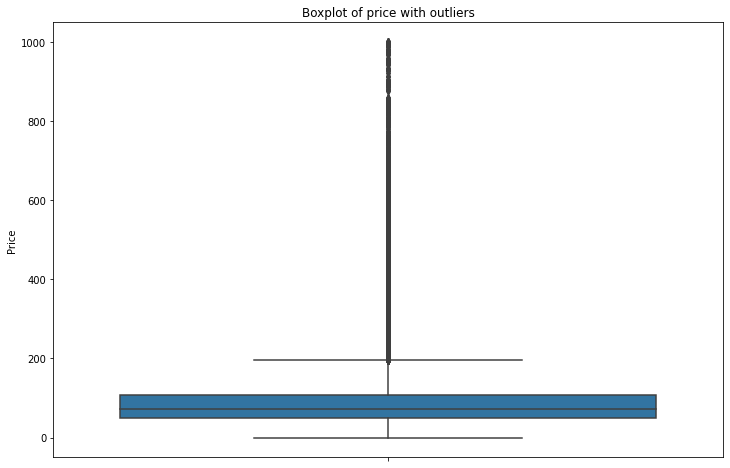

In [47]:
plt.figure(figsize=(12,8))
sns.boxplot(y='Price',data=df).set_title("Boxplot of price with outliers")

Since seems to be a lot of outlier, lets try to plot one without it.

Text(0.5, 1.0, 'Boxplot of price with no outliers')

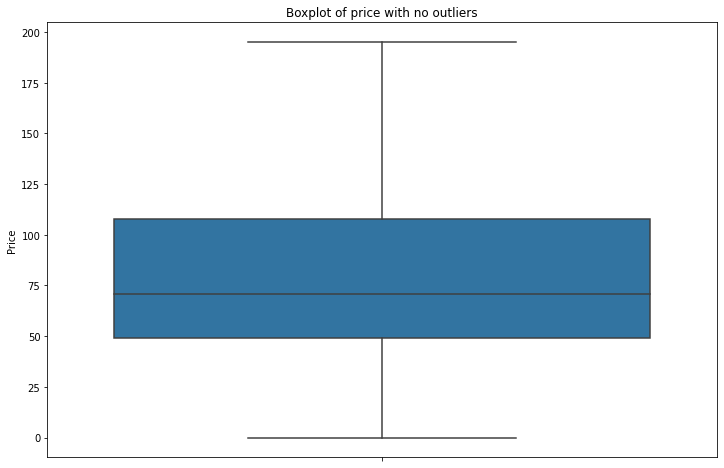

In [48]:
plt.figure(figsize=(12,8))
sns.boxplot(y='Price',data=df, showfliers=False).set_title("Boxplot of price with no outliers")

It looked much better, since if we all compartive boxplot with this much outlier, it might not look good, we can remove outlier from the boxplot as the purpose of all the plotting is just to see the distribution.

We can also plot a histogram to see the distribution of the `Price`.

Text(0.5, 1.0, 'Histogram of Price')

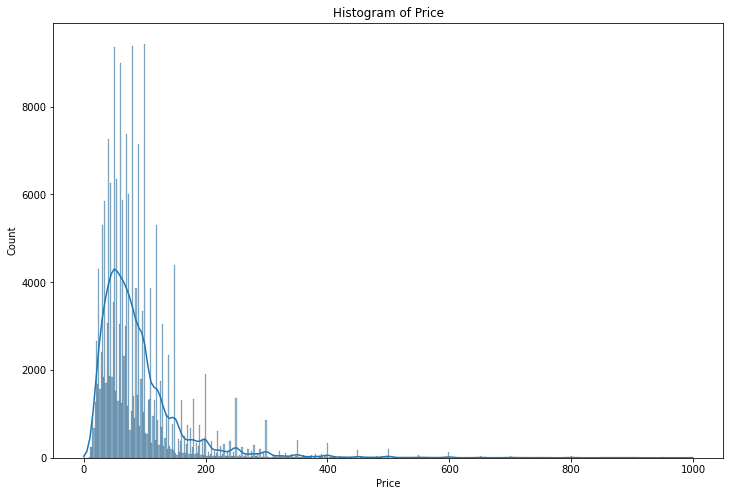

In [49]:
plt.figure(figsize=(12,8))
sns.histplot(df['Price'], kde=True).set_title("Histogram of Price")

We can see that the `Price` is skewed to right.

From the feature importance performed, we know that `Bedrooms` affects the `Price` a lot. Let's plot a barchart of `Bedrooms`.

<AxesSubplot:xlabel='Bedrooms', ylabel='count'>

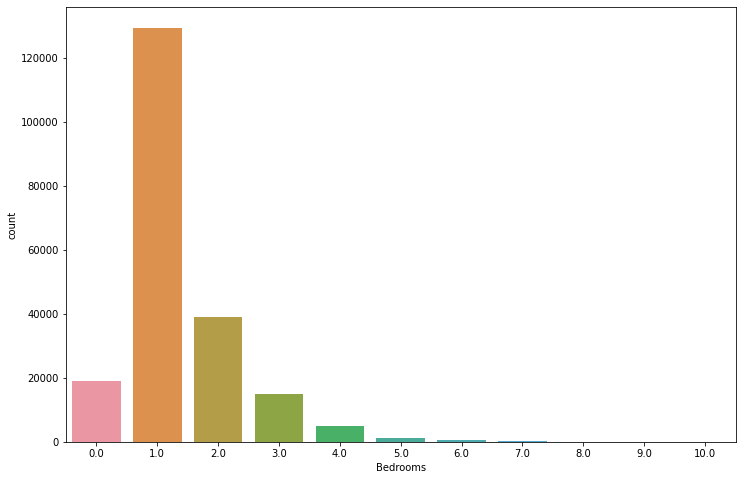

In [50]:
plt.figure(figsize=(12,8))
sns.countplot(x = 'Bedrooms', data=df)

Now that we see how bedrooms is distibuted across the data, lets see it's relationship between `Price` using a comparative boxplot.

Text(0.5, 1.0, 'Comparative boxplot of Price and Bedrooms')

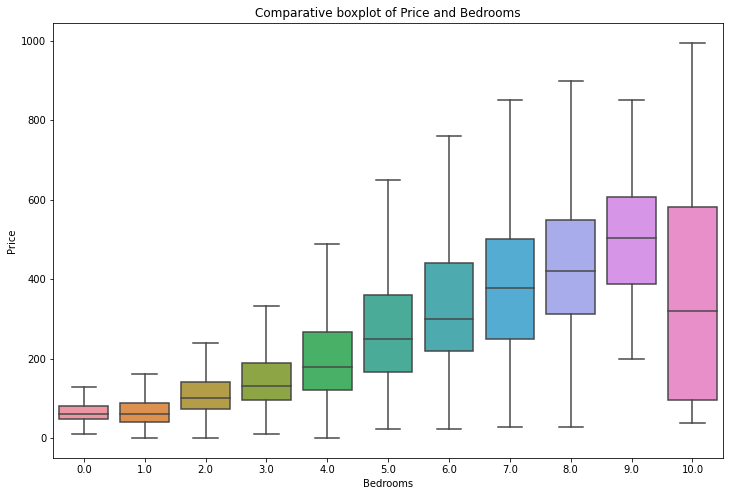

In [51]:
plt.figure(figsize=(12,8))
sns.boxplot(x='Bedrooms',y='Price',data=df, showfliers=False).set_title("Comparative boxplot of Price and Bedrooms")

We clearly can see that the price increases as bedrooms increases.

We can also do the same to `Bathrooms` to check.

Text(0.5, 1.0, 'Comparative boxplot of Price and Bathrooms')

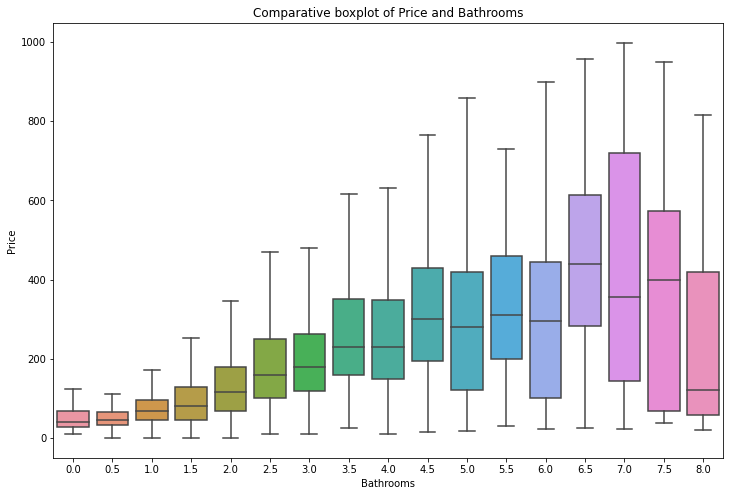

In [52]:
plt.figure(figsize=(12,8))
sns.boxplot(x='Bathrooms',y='Price',data=df, showfliers=False).set_title("Comparative boxplot of Price and Bathrooms")

From the plot we can see that `Bathrooms` has less correlation than `Bedrooms` which is inline with result of the feature improtance analysis.

Next, let's see the comparative boxplot for `Room Type` and `Price

Text(0.5, 1.0, 'Compartive boxplot of Room Types and Price')

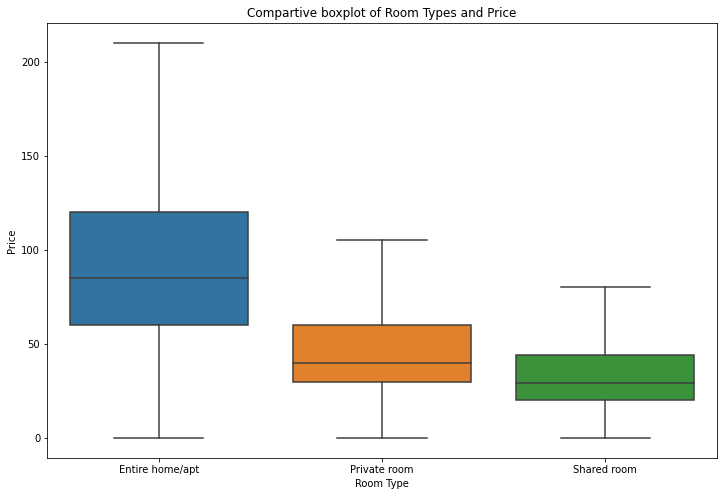

In [53]:
plt.figure(figsize=(12,8))
sns.boxplot(x='Room Type',y='Price',data=df, showfliers=False).set_title("Compartive boxplot of Room Types and Price")

From the plot we can see that `Entire home/apt` have the highest price followed by `Private room` and ` Shared room`.

We can also calculate the Price per Accomodation

In [54]:
df['Price/Accommodation'] = df['Price'] / df['Accommodates']
df[['Price', 'Accommodates', 'Price/Accommodation']]

,Price,Accommodates,Price/Accommodation
0,69.000000,4,17.250000
1,69.000000,2,34.500000
2,100.000000,3,33.333333
3,75.000000,2,37.500000
4,87.000000,3,29.000000
...,...,...,...
209410,61.558860,2,30.779430
209411,94.705938,2,47.352969
209412,42.617672,1,42.617672
209413,70.000000,5,14.000000


With that, we can compare the price between countries.

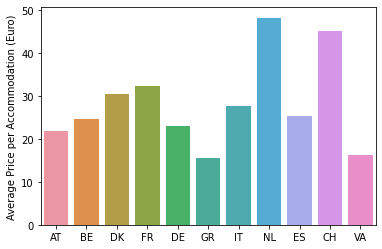

In [55]:
country_names = []
avg_price = []

for country in df['Country Code'].unique():         
    country_names.append(country)
    avg_price.append(df.loc[df['Country Code'] == country, 
                                 ['Price/Accommodation']].mean().values[0])

price_bar = sns.barplot(x=country_names, y=avg_price)
price_bar.set(ylabel='Average Price per Accommodation (Euro)')
plt.savefig('accommodation_price.png')
plt.show()

Next, let's plot the comparative boxplot of `Accommodates` and `Price`.

Text(0.5, 1.0, 'Compartive boxplot of Accommodates and Price')

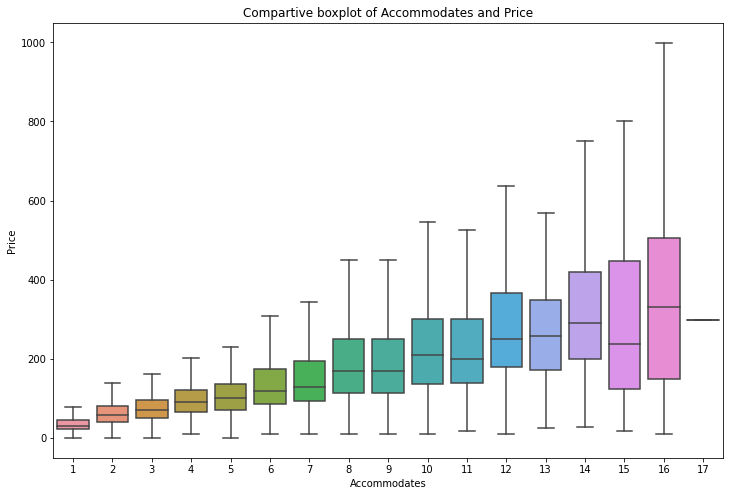

In [56]:
plt.figure(figsize=(12,8))
sns.boxplot(x='Accommodates',y='Price',data=df, showfliers=False).set_title("Compartive boxplot of Accommodates and Price")

We can see that `Accommodates` is also an important feature that affects the Price.

From the result of feature importance, `Cleaning Fee` seems to surpirsing be an important feature, lets try to make a scatter plot for it.

<AxesSubplot:title={'center':'Scatter plot of Cleaning Fee vs Price'}, xlabel='Cleaning Fee', ylabel='Price'>

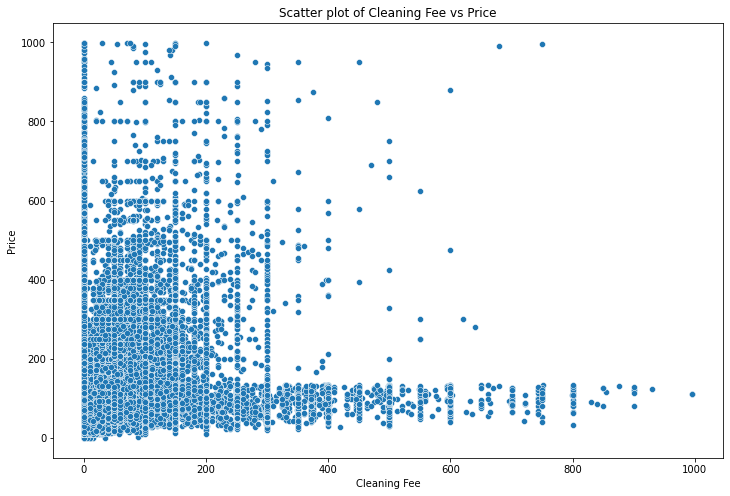

In [57]:
plt.figure(figsize=(12,8))
plt.title("Scatter plot of Cleaning Fee vs Price")
sns.scatterplot(x='Cleaning Fee',y='Price',data=df)

From the plot we can see that `Cleaning Fee` seems to have a negative correlation with the `Price` as higher `Cleaning Fee` has lower `Price`

To see how languages affect the rating polarity, we can plot a compartive boxplot to see the difference between english description and the review polarity. To do that, we can create a new column to check if the language is English.

In [58]:
def getIsEnglish(text):
    return "English" if text =='en' else "Not English"

df['Description_Language'] = df["Description Language"].apply(getIsEnglish)

In [59]:
df.head()

,ID,Description,Host Since,Host Response Time,Host Response Rate,Host Listings Count,Host Total Listings Count,Host Verifications,Neighbourhood Cleansed,City,Country Code,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,First Review,Last Review,Review Scores Rating,Cancellation Policy,Calculated host listings count,Reviews per Month,Features,Description Language,Description Polarity,review_polarity,Price/Accommodation,Description_Language
0,9902936,Gemütliches & trendiges Retro Apartment mit originären Elementen der 70er vermittelt ein authent...,2014-12-02,within an hour,100.0,9.0,9.0,"email,phone,reviews,jumio",Leopoldstadt,Wien,AT,48.215747,16.374918,Apartment,Entire home/apt,4,1.0,2.0,2.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Wheelchair accessible,Kitchen,Elevator in building,Buzzer...",69.0,150.0,59.0,2,12.0,2,1125,6 days ago,6,15,23,265,67,2016-03-26,2017-04-29,96.0,strict,4,4.90,"Host Is Superhost,Host Has Profile Pic,Host Identity Verified,Is Location Exact",de,-0.700000,0.354359,17.250000,Not English
1,16932319,Our newly renovated apartment with balcony offers privacy away from the city buzz but is close e...,2014-11-08,within a few hours,90.0,3.0,3.0,"email,phone,reviews,jumio",Leopoldstadt,Wien,AT,48.225823,16.401469,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"Kitchen,Elevator in building,Heating,Family/kid friendly,Washer,Essentials,Shampoo,Hangers,Hair ...",69.0,150.0,45.0,2,19.0,3,28,4 weeks ago,12,37,67,321,5,2017-03-05,2017-04-30,96.0,strict,1,2.27,"Host Has Profile Pic,Host Identity Verified,Instant Bookable",en,0.173817,0.000000,34.500000,English
2,4086303,"our bright one bedroom apt is located in the center of vienna, in a neighborhood full of restau...",2010-08-27,within a few hours,100.0,1.0,1.0,"email,phone,reviews,work_email",Leopoldstadt,Vienna,AT,48.214652,16.379914,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,"TV,Wireless Internet,Kitchen,Heating,Family/kid friendly,Washer,Essentials,Hangers,Iron,Laptop f...",100.0,164.0,65.0,3,20.0,2,1125,5 weeks ago,3,33,63,338,3,2017-01-02,2017-04-24,93.0,strict,1,0.70,"Host Has Profile Pic,Is Location Exact",en,0.254762,0.363049,33.333333,English
3,13112862,Mein Premium Apartment Elegance ist in einem klassischen Wiener Jahrhundertwendehaus. Das Apartm...,2012-02-14,within an hour,100.0,3.0,3.0,"email,phone,facebook,reviews,jumio",Leopoldstadt,Wien,AT,48.222464,16.387926,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen,Elevator in building,Buzzer/wireless intercom,Hea...",75.0,0.0,40.0,1,0.0,2,185,today,5,9,32,302,50,2016-07-18,2017-05-05,100.0,strict,3,5.07,"Host Is Superhost,Host Has Profile Pic,Host Identity Verified,Is Location Exact,Instant Bookable",de,0.000000,0.321735,37.500000,Not English
4,16945823,Einen Katzensprung vom Stephansdom und der City entfernt. Unsere Wohnung ist ein gemütlicher Rüc...,2015-09-02,within an hour,100.0,2.0,2.0,"phone,reviews",Leopoldstadt,Wien,AT,48.216764,16.384622,Apartment,Entire home/apt,3,1.0,2.0,2.0,Real Bed,"TV,Wireless Internet,Kitchen,Elevator in building,Heating,Family/kid friendly,Essentials,Shampoo...",87.0,0.0,45.0,2,12.0,1,1125,a week ago,19,49,79,348,2,2017-04-17,2017-04-29,100.0,moderate,1,2.00,Host Has Profile Pic,de,0.106250,0.000000,29.000000,Not English


Now we can see do the comparative boxplot

<AxesSubplot:xlabel='Description_Language', ylabel='review_polarity'>

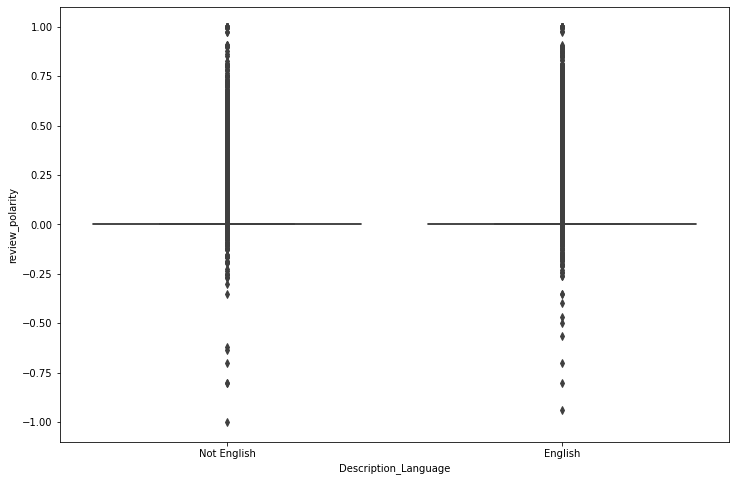

In [60]:
plt.figure(figsize=(12,8))
sns.boxplot(x='Description_Language',y='review_polarity',data=df)

It seems that setting polarity to 0 is affecting the boxplot by a lot, lets remove all the 0 review_polarity

In [61]:
df = df.loc[(df.review_polarity!=0)]

Now let's plot again

Text(0.5, 1.0, 'Comparative Boxplot for review polarity and Description Language')

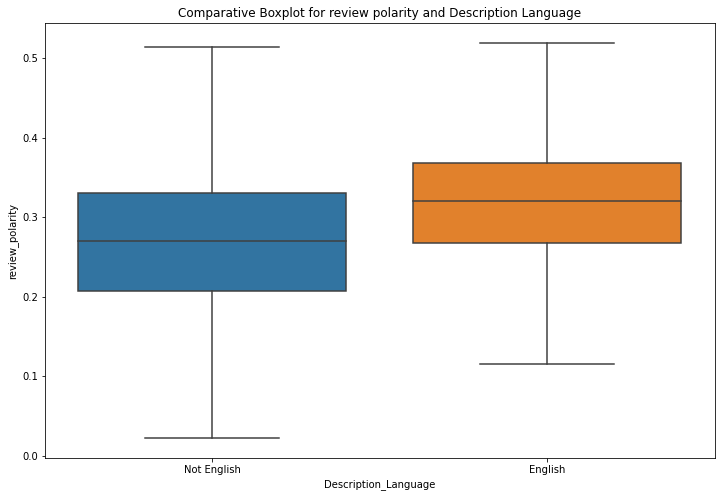

In [62]:
plt.figure(figsize=(12,8))
sns.boxplot(x='Description_Language',y='review_polarity',data=df, showfliers=False ).set_title("Comparative Boxplot for review polarity and Description Language")

From the plot we can see that English description has a higher review polarity.

To see how review polarity can affect the `Price`, we can do a scatter plot.

<AxesSubplot:xlabel='Price', ylabel='review_polarity'>

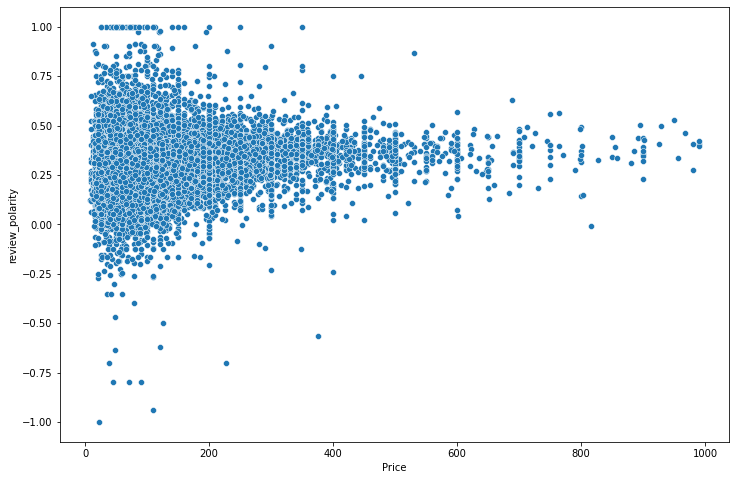

In [63]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='Price',y='review_polarity',data=df)

Since the distribution seems not balanced, we can try to do log scaling for the `Price`.

In [64]:
scaled_price_df = df.copy()
scaled_price_df['Price'] =  np.log(scaled_price_df['Price'])

Now we can try again with the scaled price

<AxesSubplot:title={'center':'Scatter plot of review polarity and log(Price)'}, xlabel='Price', ylabel='review_polarity'>

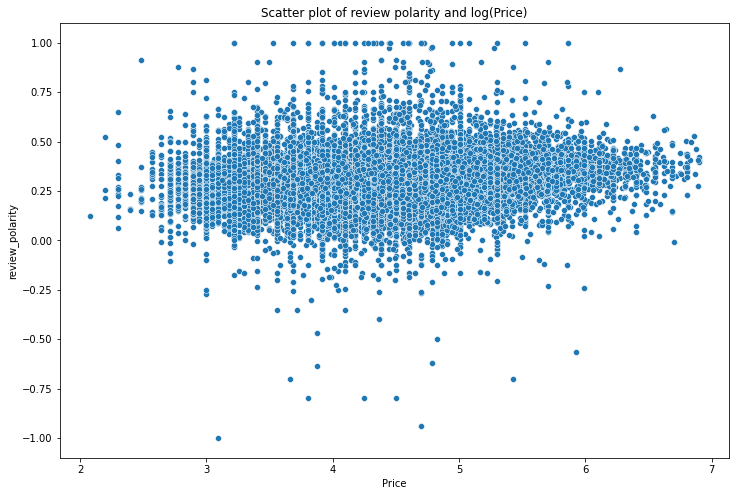

In [65]:
plt.figure(figsize=(12,8))
plt.title("Scatter plot of review polarity and log(Price)")
sns.scatterplot(x='Price',y='review_polarity',data=scaled_price_df)

From the plot we can now clearly see that `Price` and review polarity have not much correlation.

We can also get the Worst Rated Airbnb by Review Polarity and Review Score Rating

In [66]:
min_reviews = df[df['Number of Reviews'] >= 5]

In [67]:
worst = min_reviews.nsmallest(1, ['Review Scores Rating', 'review_polarity'])
worst.T

,148316
ID,9884602
Description,"Roof terrace, kitchen, 2 toilets, 1 bathroom, large room with french balcony, the middle of Ams..."
Host Since,2015-06-12
Host Response Time,within an hour
Host Response Rate,100
Host Listings Count,2
Host Total Listings Count,2
Host Verifications,"email,phone,reviews"
Neighbourhood Cleansed,De Baarsjes - Oud-West
City,Amsterdam


Other than that we can also get the Best Rated Airbnb by Review Polarity and Review Score Rating 

In [68]:
best = min_reviews.nlargest(1, ['Review Scores Rating', 'review_polarity'])
best.T

,92739
ID,16853223
Description,I am renting out my lovely 50m2 apartment on the 4th floor. The flat is located in a quiet but c...
Host Since,2017-01-11
Host Response Time,within an hour
Host Response Rate,100
Host Listings Count,1
Host Total Listings Count,1
Host Verifications,"email,phone,reviews,jumio,offline_government_id,government_id"
Neighbourhood Cleansed,Frankfurter Allee Süd FK
City,Berlin


To gain more insight of airbnb in specific city, we can use the Germany data as it has only 1 city from the dataset.

In [69]:
df_germany = df[df["Country Code"] == "DE"].copy()

Now that we got the dataframe focusing on Germany, let see how is the price distribution comparing to the original dataframe

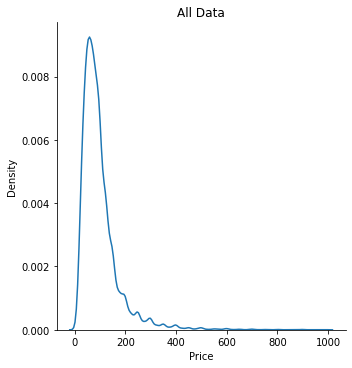

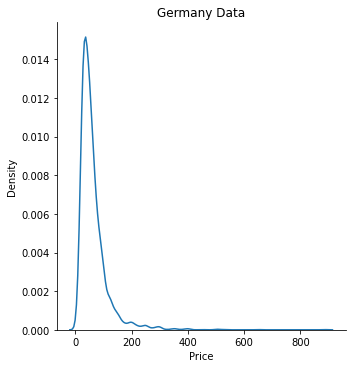

In [70]:
sns.displot(df['Price'], kind="kde").set(title='All Data')
sns.displot(df_germany['Price'],  kind="kde").set(title='Germany Data')

We can see that the distribution of Germany Data is more skinnier.

We can also checkout the histogram for the `Price` of Germany

Text(0.5, 1.0, 'Price of Germany before removing outlier')

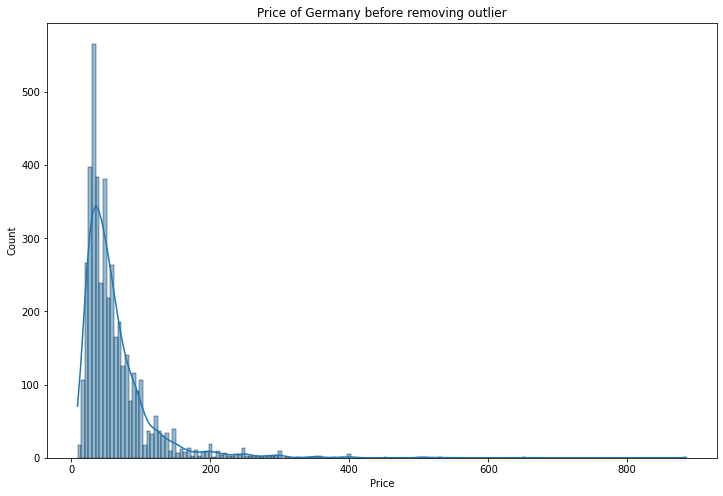

In [71]:
plt.figure(figsize=(12,8))
sns.histplot(df_germany['Price'], kde=True).set_title("Price of Germany before removing outlier")

Since there seems to be a lots of outliers, lets reduce them for the Germany data.

In [72]:
#gets the upper bound and lower bound
q1 = df_germany.Price.quantile(.25)
q3 = df_germany.Price.quantile(.75)
iqr = q3-q1
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

#create new data we reduced outlier
df_germany_no_outliers = df_germany[(df_germany["Price"] <= upper_bound ) & (df_germany["Price"] >= lower_bound)].copy()

Text(0.5, 1.0, 'Price of Germany data after removing outliers')

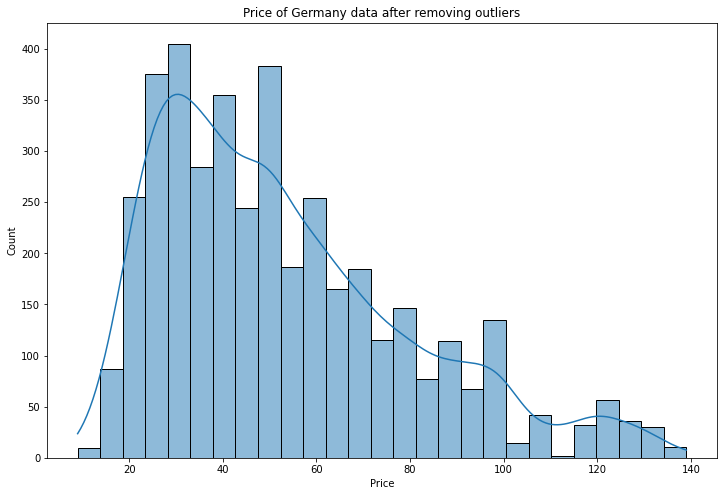

In [73]:
plt.figure(figsize=(12,8))
sns.histplot(df_germany_no_outliers['Price'], kde=True).set_title("Price of Germany data after removing outliers")

Now the shape of the data look so much more even. We can see how does the being closer to city center affect the price.

In [74]:
# gets the distance to center
mean_longitude = df_germany_no_outliers["Longitude"].mean()
mean_latitude = df_germany_no_outliers["Latitude"].mean()
df_germany_no_outliers["Distance to Center"] = ((df_germany_no_outliers["Longitude"] - mean_longitude) ** 2
                               + (df_germany_no_outliers["Latitude"] - mean_latitude) ** 2) ** (1/2)

<AxesSubplot:title={'center':'Scatter plot of Distance to Center and Price'}, xlabel='Price', ylabel='Distance to Center'>

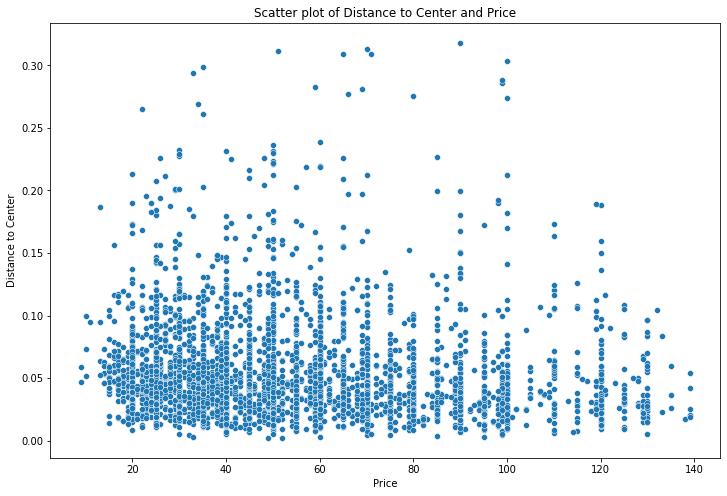

In [75]:
plt.figure(figsize=(12,8))
plt.title("Scatter plot of Distance to Center and Price")
sns.scatterplot(x='Price',y='Distance to Center',data=df_germany_no_outliers)

Lastly, we can plot a heatmap using the `Latitude` and `Longitude`

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

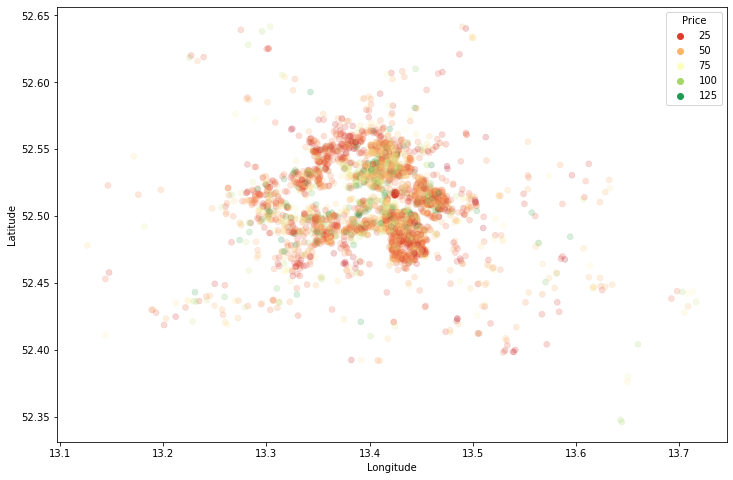

In [76]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='Longitude',y='Latitude',
                data=df_germany_no_outliers,hue='Price',
                palette='RdYlGn',edgecolor=None,alpha=0.2)

In [77]:
from IPython.display import Image
Image(url= "berlin_basemap.png", width=800, height=600)

From the image we can see that there are more units closer to the center of Berlin.